# HeatPumpMonitor.org `API` example
Part of the OpenEnergyMonitor project: 
https://openenergymonitor.org

In [1]:
import sys
import os
import json
import requests
import datetime

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from tabulate import tabulate

sys.path.insert(0, os.path.abspath(os.path.join('..', 'module')))

from globalset import *
from parser import *

project path ➥ /Users/gustavo/Desktop/heat-pump-monitor


## Retrieve summary data from API

In [2]:
meta = fetch_public_devices()

with open(os.path.join(DATA_DIR, 'metadata.json'), 'w') as f:
    json.dump(meta, f)

In [3]:
stats = fetch_public_devices_last_stats()

with open(os.path.join(DATA_DIR, 'last_90_days.json'), 'w') as f:
    json.dump(stats, f)

## Convert the stats dictionary to a pandas DataFrame

In [4]:
stats_df = pd.json_normalize(stats.values())
meta_df = pd.json_normalize(meta)
merged_df = pd.merge(stats_df, meta_df, on='id')
merged_df.to_csv(os.path.join(DATA_DIR, 'merged_stats_meta.csv'), index=False)

In [5]:
selected_columns = merged_df[['id', 'location', 'property', 'age', 'hp_output', 'hp_model', 'combined_cop', 'combined_data_length']].copy()
selected_columns.loc[:, 'days'] = selected_columns['combined_data_length'] / 86400
selected_columns.drop(columns=['combined_data_length'], inplace=True)
selected_columns.rename(columns={'combined_cop': 'cop'}, inplace=True)
selected_columns.sort_values(by='cop', ascending=False, inplace=True)

print("HeatPumpMonitor.org systems (sorted by COP, descending, last 90 days)")
print(tabulate(selected_columns, headers='keys', tablefmt='psql'))

HeatPumpMonitor.org systems (sorted by COP, descending, last 90 days)
+-----+------+------------------------------------+-------------------+---------------+-------------+------------------------------------------+-----------+-------------+
|     |   id | location                           | property          | age           |   hp_output | hp_model                                 |       cop |        days |
|-----+------+------------------------------------+-------------------+---------------+-------------+------------------------------------------+-----------+-------------|
| 152 |  204 | Caersws, Mid Wales                 | Detached          | 2012 or newer |       12    | Stiebel Eltron WPE-I 12 H 230            |   6.3138  | 87.9597     |
| 364 |  546 | Sint Maarten, The Netherlands      | Detached          | 1940 to 1982  |        5    | Vaillant Arotherm+                       |   5.68046 | 87.7388     |
| 172 |  153 | Finchampstead                      | Detached          | 198

## Obtain summary from heat pump `by id`

In [6]:
k_id = 152

metaid = get_system_meta(k_id)
print(tabulate(metaid.items(), headers=["Key", "Value"], tablefmt="psql"))

+--------------------------------------+----------------------------------------------------------------------------------------+
| Key                                  | Value                                                                                  |
|--------------------------------------+----------------------------------------------------------------------------------------|
| id                                   | 152                                                                                    |
| userid                               | 185                                                                                    |
| published                            | 1                                                                                      |
| last_updated                         | 1729081079                                                                             |
| location                             | Gwent                                            

## Obtain **timeseries** from heat pump `by id`

Display available feeds first...

In [7]:
ts_id = get_system_timeseries(k_id)
print(tabulate(ts_id, headers="keys", tablefmt="psql"))

+-------------------+---------------------+---------------------+---------------+-----------+
|                   | start_time          | end_time            |   interval__s |   npoints |
|-------------------+---------------------+---------------------+---------------+-----------|
| heatpump_elec     | 2024-01-06 16:30:40 | 2025-01-03 12:15:20 |            10 |   3134789 |
| heatpump_elec_kwh | 2024-01-06 16:30:40 | 2025-01-03 12:15:20 |            10 |   3134789 |
| heatpump_heat     | 2023-12-08 15:00:10 | 2025-01-03 12:15:20 |            10 |   3385892 |
| heatpump_heat_kwh | 2023-12-08 15:00:10 | 2025-01-03 12:15:20 |            10 |   3385892 |
| heatpump_flowT    | 2023-12-08 15:00:10 | 2025-01-03 12:15:20 |            10 |   3385892 |
| heatpump_returnT  | 2023-12-08 15:00:10 | 2025-01-03 12:15:20 |            10 |   3385892 |
| heatpump_flowrate | 2023-12-08 15:00:10 | 2025-01-03 12:15:20 |            10 |   3385892 |
| heatpump_outsideT | 2023-12-08 13:00:00 | 2025-01-05 11:00

And then request a feed for that id...

In [21]:
k_variable = 'heatpump_outsideT'
k_from = '06-01-2024'
k_to = '03-01-2025'
k_resolution = 3600

timeseries = fetch_timeseries_data(k_id, k_variable, k_from, k_to, k_resolution, 1)
print(tabulate(timeseries.head(), headers="keys", tablefmt="psql"))

+----+------+---------------------+---------+-------------------+
|    |   id | datetime            |   value | feed              |
|----+------+---------------------+---------+-------------------|
|  0 |  152 | 2024-01-06 00:00:00 |    5.81 | heatpump_outsideT |
|  1 |  152 | 2024-01-06 01:00:00 |    6.78 | heatpump_outsideT |
|  2 |  152 | 2024-01-06 02:00:00 |    7.23 | heatpump_outsideT |
|  3 |  152 | 2024-01-06 03:00:00 |    6.8  | heatpump_outsideT |
|  4 |  152 | 2024-01-06 04:00:00 |    6.47 | heatpump_outsideT |
+----+------+---------------------+---------+-------------------+


## Combine feeds

In [23]:
index_interval_pairs = list(ts_id['interval__s'].items())
print(index_interval_pairs)

d_timeseries = {}
for k_variable, k_resolution in index_interval_pairs:
    k_res = k_resolution
    k_res = 3600
    timeseries = fetch_timeseries_data(k_id, k_variable, k_from, k_to, k_res, 1)
    d_timeseries[k_variable] = timeseries

combined_df = pd.concat(d_timeseries.values(), keys=d_timeseries.keys(), names=['variable', 'index']).reset_index(level='variable')
combined_df.reset_index(inplace=True)
combined_df.drop(columns=['index', 'variable'], inplace=True)
combined_df.head()

[('heatpump_elec', 10), ('heatpump_elec_kwh', 10), ('heatpump_heat', 10), ('heatpump_heat_kwh', 10), ('heatpump_flowT', 10), ('heatpump_returnT', 10), ('heatpump_flowrate', 10), ('heatpump_outsideT', 3600)]


,id,datetime,value,feed
0,152,2024-01-06 00:00:00,NaN,heatpump_elec
1,152,2024-01-06 01:00:00,NaN,heatpump_elec
2,152,2024-01-06 02:00:00,NaN,heatpump_elec
3,152,2024-01-06 03:00:00,NaN,heatpump_elec
4,152,2024-01-06 04:00:00,762.765219,heatpump_elec


In [24]:
k_variable = 'heatpump_outsideT'
timeseries_a = combined_df.loc[combined_df['feed'] == k_variable]

k_variable = 'heatpump_roomT'
timeseries_b = combined_df.loc[combined_df['feed'] == k_variable]

k_variable = 'heatpump_elec'
timeseries_c = combined_df.loc[combined_df['feed'] == k_variable]

k_variable = 'heatpump_heat'
timeseries_d = combined_df.loc[combined_df['feed'] == k_variable]

k_variable = 'heatpump_elec_kwh'
timeseries_e = combined_df.loc[combined_df['feed'] == k_variable]

k_variable = 'heatpump_heat_kwh'
timeseries_f = combined_df.loc[combined_df['feed'] == k_variable]

k_variable = 'heatpump_flowT'
timeseries_g = combined_df.loc[combined_df['feed'] == k_variable]

k_variable = 'heatpump_returnT'
timeseries_h = combined_df.loc[combined_df['feed'] == k_variable]

k_variable = 'heatpump_flowrate'
timeseries_i = combined_df.loc[combined_df['feed'] == k_variable]

k_variable = 'heatpump_dhw'
timeseries_j = combined_df.loc[combined_df['feed'] == k_variable]

timeseries_k = pd.merge(timeseries_a, timeseries_g, on='datetime')
timeseries_k['deltaT'] = timeseries_k['value_y'] - timeseries_k['value_x']
timeseries_k = timeseries_k[['datetime', 'deltaT']]

timeseries_l = pd.merge(timeseries_c, timeseries_d, on='datetime')
timeseries_l['cop'] = timeseries_l['value_y'] / timeseries_l['value_x']
timeseries_l = timeseries_l[['datetime', 'cop']]

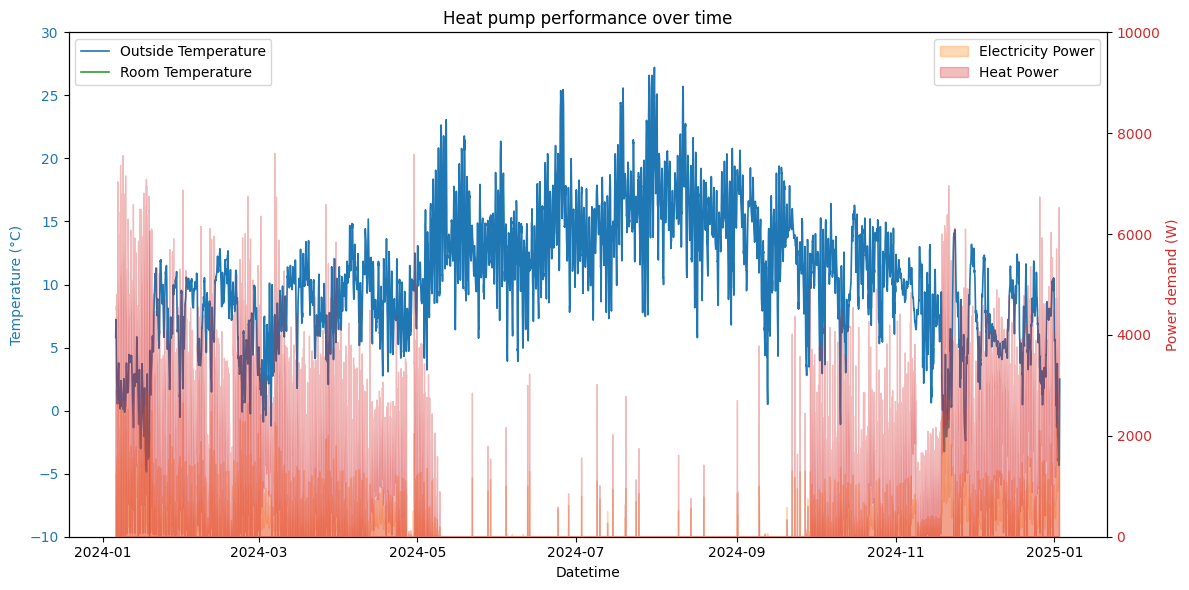

In [25]:
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Datetime')
ax1.set_ylabel('Temperature (°C)', color=color)
ax1.set_ylim(-10, 30)
sns.lineplot(data=timeseries_a, x='datetime', y='value', 
             label='Outside Temperature', ax=ax1, color=color, linewidth=1.2)
sns.lineplot(data=timeseries_b, x='datetime', y='value', 
             label='Room Temperature', ax=ax1, color='tab:green', linewidth=1.2)
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Power demand (W)', color=color)
ax2.set_ylim(0, 10000)
ax2.fill_between(timeseries_c['datetime'], timeseries_c['value'], color='tab:orange', alpha=0.3, label='Electricity Power')
ax2.fill_between(timeseries_d['datetime'], timeseries_d['value'], color=color, alpha=0.3, label='Heat Power')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

plt.title('Heat pump performance over time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

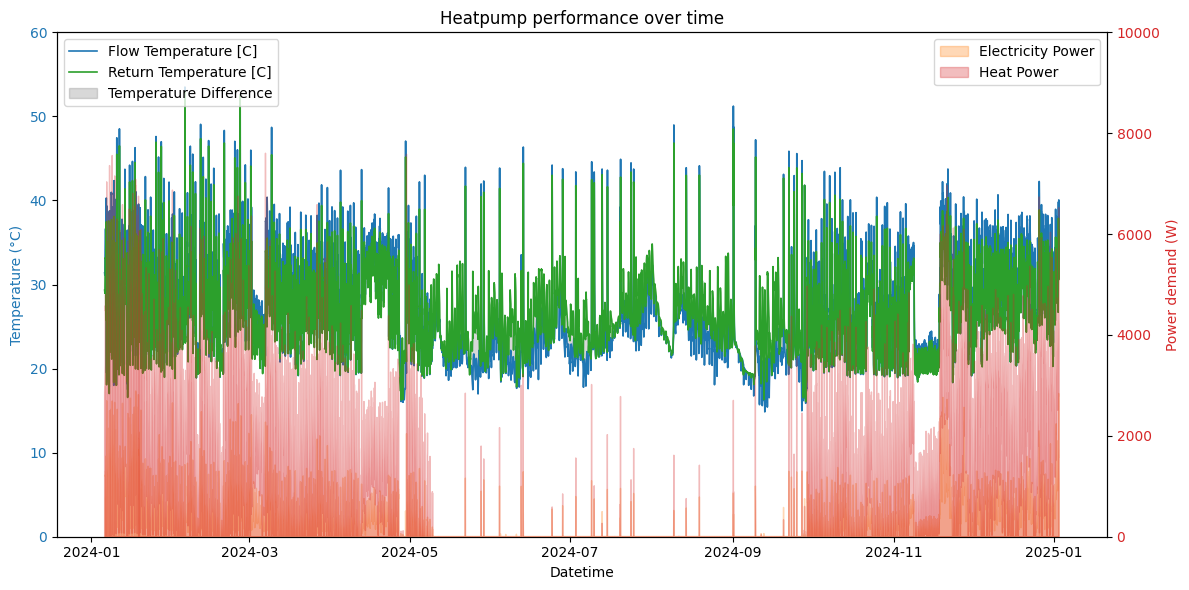

In [26]:
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Datetime')
ax1.set_ylabel('Temperature (°C)', color=color)
ax1.set_ylim(0, 60)
sns.lineplot(data=timeseries_g, x='datetime', y='value',
             label='Flow Temperature [C]', ax=ax1, color=color, linewidth=1.2)
sns.lineplot(data=timeseries_h, x='datetime', y='value',
             label='Return Temperature [C]', ax=ax1, color='tab:green', linewidth=1.2)
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')

ax1.fill_between(timeseries_g['datetime'], timeseries_g['value'],
                 timeseries_h['value'], color='gray', alpha=0.3, label='Temperature Difference')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Power demand (W)', color=color)
ax2.set_ylim(0, 10000)
ax2.fill_between(timeseries_c['datetime'], timeseries_c['value'], color='tab:orange', alpha=0.3, label='Electricity Power')
ax2.fill_between(timeseries_d['datetime'], timeseries_d['value'], color=color, alpha=0.3, label='Heat Power')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

plt.title('Heatpump performance over time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

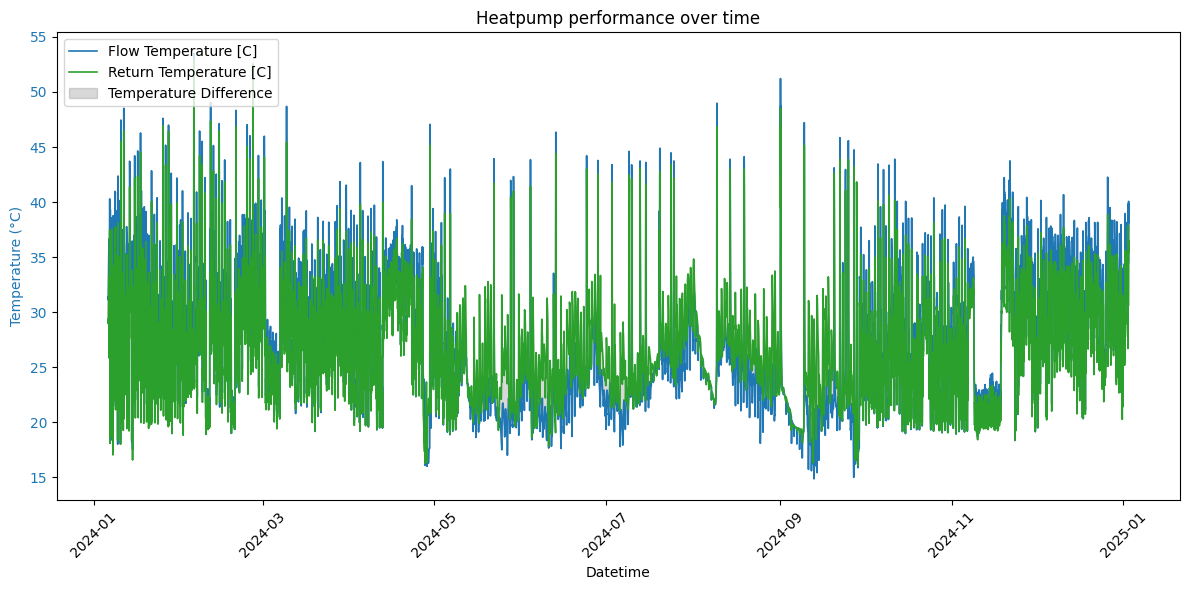

In [27]:
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Datetime')
ax1.set_ylabel('Temperature (°C)', color=color)
# ax1.set_ylim(0, 60)
sns.lineplot(data=timeseries_g, x='datetime', y='value', 
             label='Flow Temperature [C]', ax=ax1, color=color, linewidth=1.2)
sns.lineplot(data=timeseries_h, x='datetime', y='value', 
             label='Return Temperature [C]', ax=ax1, color='tab:green', linewidth=1.2)
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')

ax1.fill_between(timeseries_g['datetime'], timeseries_g['value'],
                 timeseries_h['value'], color='gray', alpha=0.3, label='Temperature Difference')
ax1.legend(loc='upper left')

plt.title('Heatpump performance over time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

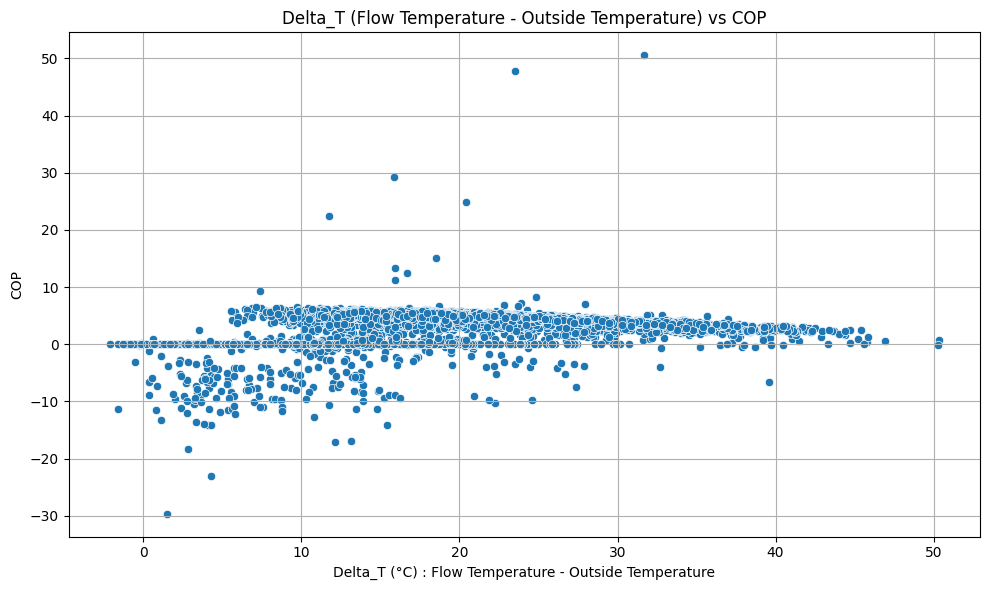

In [28]:
timeseries_kl = pd.merge(timeseries_k, timeseries_l, on='datetime')
timeseries_kl

plt.figure(figsize=(10, 6))
sns.scatterplot(data=timeseries_kl, x='deltaT', y='cop')
plt.title('Delta_T (Flow Temperature - Outside Temperature) vs COP')
plt.xlabel('Delta_T (°C) : Flow Temperature - Outside Temperature')
plt.ylabel('COP')
plt.grid(True)
plt.tight_layout()
plt.show()

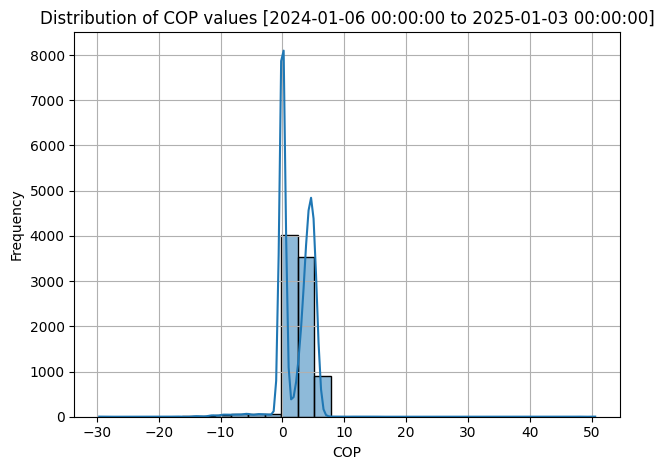

In [29]:
# Indicate the period range defined by the column 'datetime'
start_date = timeseries_l['datetime'].min()
end_date = timeseries_l['datetime'].max()
plot_title = f"[{start_date} to {end_date}]"

sns.histplot(data=timeseries_l, x='cop', bins=30, kde=True)
plt.title('Distribution of COP values ' + plot_title)
plt.xlabel('COP')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()